In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import os

#from py_files.c_target_exploration import mod_concat_NEMDE
#from py_files.d_concat_DUID_marginal_fuelsource import *

In [8]:
def mod_concat_NEMDE(file_path):
    '''
    load modified df of concatenated pkl chunks after clean_filter_concat_pkl func application
    '''
    df = pd.read_pickle(file_path)
    df.drop(columns=["BandNo","RRNBandPrice","BandCost"], inplace=True)
    df = df.set_index('PeriodID', drop=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df[["Price", "Increase"]] = df[["Price", "Increase"]].astype(float)
    df.rename(columns={"Unit":"DUID"}, inplace=True)
    df.sort_index(inplace=True, ascending=False)
    df.index = df.index - dt.timedelta(minutes = 5)
    df = df.loc[df.index < dt.datetime(2018,8,1), :]
    
    assert df["Price"].dtype == float
    assert df["Increase"].dtype == float
    assert df.isna().any().any() == False
    
    return df

In [9]:
file_path = '{}/nem-data/nemde_clean/concat_for_energy_SA1.pkl'.format(os.environ['HOME'])
df = mod_concat_NEMDE(file_path)

In [10]:
df.head(100)

,RegionID,Market,Price,DUID,DispatchedMarket,Increase
PeriodID,,,,,,
2018-07-31 23:55:00,SA1,Energy,70.70204,ER01,ENOF,0.34712
2018-07-31 23:55:00,SA1,Energy,70.70204,ER04,ENOF,0.31058
2018-07-31 23:55:00,SA1,Energy,70.70204,ER03,ENOF,0.34712
2018-07-31 23:55:00,SA1,Energy,70.70204,ER02,ENOF,0.31058
2018-07-31 23:50:00,SA1,Energy,69.24109,DEVILS_G,L5MI,-1.29132
...,...,...,...,...,...,...
2018-07-31 22:20:00,SA1,Energy,79.30359,ER03,ENOF,0.42336
2018-07-31 22:15:00,SA1,Energy,81.25001,TORRB3,R5MI,0.33333
2018-07-31 22:15:00,SA1,Energy,81.25001,TARONG#1,R5MI,-1.00000


In [11]:
file_path = '{}/Desktop/Portfolio_project/DUID_CO2.csv'.format(os.environ['HOME'])
CO2_generators = pd.read_csv(file_path)
print(CO2_generators.DUID.nunique())
CO2_generators.head()

384


,DUID,GENSETID,REGIONID,CO2E_EMISSIONS_FACTOR,CO2E_ENERGY_SOURCE,CO2E_DATA_SOURCE
0,AGLNOW1,AGLNOW1,NSW1,0.062,Landfill biogas methane,NGA 2018
1,AGLSITA1,AGLSITA1,NSW1,0.062,Landfill biogas methane,NGA 2018
2,APPIN,APPIN,NSW1,0.765,Coal seam methane,NGA 2018
3,BDONGHYD,BDONGHYD,NSW1,0.000,Hydro,ISP 2018
4,BERYLSF1,BERYLSF1,NSW1,0.000,Solar,ISP 2018


In [15]:
def DUID_items(NEMDE_market_df, CO2_generators_df):
    '''
    The function needs dataframes with the generator ID columns named "DUID" in each case.
    A list variable is returned
    '''
    lst1 = []
    for i in set(NEMDE_market_df.DUID):
        if i in set(CO2_generators_df.DUID):
            lst1.append(i)
    print('The NEMDE_market_table uses {} DUID items from the DUID CO2_generator column.'.format(len(lst1)))
    
    lst2 = []
    for i in set(NEMDE_market_df.DUID):
        if i in set(CO2_generators_df.GENSETID):
            lst2.append(i)
    print('The NEMDE_market_table uses {} DUID items from the GENSETID CO2_generator column.'.format(len(lst2)))
    
    lst_diff =[]
    for i in lst2:
        if i not in lst1:
            lst_diff.append(i)
    print('The items {} from the GENSETID column should be added to the DUID column.'.format(lst_diff))
    return lst_diff

def merge_DUID_GENSETID(CO2_generators_df, lst_diff):
    '''
    This function takes care of the mismatch output by DUID_items. Note that .groupby("DUID").mean() is applied to the
    CO2_generators table. Hence, only numerical columns are returned.
    The mismatch list lst_diff must be the output from DUID_items
    '''
    CO2_generators_grouped = CO2_generators_df.groupby("DUID").mean().reset_index()
    count = -1
    for i in CO2_generators_df.GENSETID:
        count += 1
        if i in lst_diff:
            CO2_generators_grouped = pd.concat([CO2_generators_grouped, CO2_generators_df.iloc[[count],:]\
                                                .loc[:,["GENSETID","CO2E_EMISSIONS_FACTOR"]].rename(columns={"GENSETID":"DUID"})],)
    CO2_generators_grouped = CO2_generators_grouped.sort_values(by="DUID").reset_index(drop=True)
    return CO2_generators_grouped

In [13]:
lst_diff = DUID_items(df, CO2_generators)

The NEMDE_market_table uses 177 DUID items from the DUID CO2_generator column.
The NEMDE_market_table uses 163 DUID items from the GENSETID CO2_generator column.
The items ['ANGAS1', 'ANGAS2', 'MCKAY2'] from the GENSETID column should be added to the DUID column.


In [16]:
all_DUIDs = merge_DUID_GENSETID(CO2_generators, lst_diff)
print(all_DUIDs.DUID.nunique())
all_DUIDs.head()

387


,DUID,CO2E_EMISSIONS_FACTOR
0,AGLHAL,1.174440
1,AGLNOW1,0.062000
2,AGLSITA1,0.062000
3,AGLSOM,0.817915
4,ANGAS1,1.013600


In [105]:
file_path = '{}/nem-data/nemde_clean/all_DUIDs.pkl'.format(os.environ['HOME'])
pd.to_pickle(all_DUIDs, file_path)

In [17]:
df_DUID_CO2 = df.reset_index().merge(all_DUIDs, how="left", on="DUID").set_index("PeriodID")
df_DUID_CO2 = df_DUID_CO2.drop(columns=["RegionID", "Market", "DispatchedMarket", "Increase"])
print(df_DUID_CO2.shape)
df_DUID_CO2

(5951707, 3)


,Price,DUID,CO2E_EMISSIONS_FACTOR
PeriodID,,,
2018-07-31 23:55:00,70.70204,ER01,0.910143
2018-07-31 23:55:00,70.70204,ER04,0.910143
2018-07-31 23:55:00,70.70204,ER03,0.910143
2018-07-31 23:55:00,70.70204,ER02,0.910143
2018-07-31 23:50:00,69.24109,DEVILS_G,0.000000
...,...,...,...
2009-07-01 04:00:00,1.35918,ER03,0.910143
2009-07-01 04:00:00,1.35918,ER04,0.910143
2009-07-01 04:00:00,1.35918,"ENOF,YWPS2,2,YWPS3,2",NaN


In [18]:
print(df_DUID_CO2[~df_DUID_CO2.CO2E_EMISSIONS_FACTOR.isna()].shape)
df_DUID_CO2 = df_DUID_CO2[~df_DUID_CO2.CO2E_EMISSIONS_FACTOR.isna()]
print(df_DUID_CO2.isna().any())
df_DUID_CO2

(2886240, 3)
Price                    False
DUID                     False
CO2E_EMISSIONS_FACTOR    False
dtype: bool


,Price,DUID,CO2E_EMISSIONS_FACTOR
PeriodID,,,
2018-07-31 23:55:00,70.70204,ER01,0.910143
2018-07-31 23:55:00,70.70204,ER04,0.910143
2018-07-31 23:55:00,70.70204,ER03,0.910143
2018-07-31 23:55:00,70.70204,ER02,0.910143
2018-07-31 23:50:00,69.24109,DEVILS_G,0.000000
...,...,...,...
2009-07-01 04:00:00,1.35918,ER02,0.910143
2009-07-01 04:00:00,1.35918,ER03,0.910143
2009-07-01 04:00:00,1.35918,ER04,0.910143


In [19]:
df_DUID_CO2_CO2 = df_DUID_CO2.groupby(df_DUID_CO2.index).mean().sort_index(ascending=False)
print(df_DUID_CO2_CO2.shape)
df_DUID_CO2_CO2.head()

(911397, 2)


,Price,CO2E_EMISSIONS_FACTOR
PeriodID,,
2018-07-31 23:55:00,70.70204,0.910143
2018-07-31 23:50:00,69.24109,0.728114
2018-07-31 23:45:00,69.94850,0.910143
2018-07-31 23:40:00,74.04497,0.908305
2018-07-31 23:35:00,76.44245,0.971761


In [20]:
print(df_DUID_CO2_CO2.Price.max())
print(df_DUID_CO2_CO2.Price.min())
print(sum(df_DUID_CO2_CO2.Price > 13500))
print(sum(df_DUID_CO2_CO2.Price < -1000))

1202903.49417
-26801.01056999999
156
65


In [68]:
df_DUID_CO2_price = df_DUID_CO2_CO2.query('Price > -1000 and Price < 13500')
print(sum(df_DUID_CO2_price.Price > 13500))
print(sum(df_DUID_CO2_price.Price < -1000))

0
0


In [24]:
len(pd.date_range(start='2009-07-01 04:00:00', end='2018-07-31 23:55:00', freq='5min'))

955536

In [130]:
def correct_timedelta(df, time_diff):
    '''
    df.index must be DateTimeIndex
    table=table_of_interest
    col="column_of_interest"
    time_diff=time_diff in seconds as int
    '''
    lst = []
    lst_i = []
    count = 0
    for i in df.index:
        count += 1
        if count >= len(df):
            break
        delta = abs(df.index[count] - df.index[count-1])
        if int(delta.total_seconds()) != int(time_diff):
            lst.append(("from index {} on, it has been {} s or {} h.".format(count-1,int(delta.total_seconds()),(int(delta.total_seconds()/3600)))))
            lst_i.append((count-1,int(delta.total_seconds())))
    return lst, lst_i

In [131]:
a1,b1 = correct_timedelta(df_DUID_CO2_CO2, 300)

In [132]:
len(a1)

24983

In [133]:
a2,b2 = correct_timedelta(df_DUID_CO2_price, 300)

In [134]:
len(a2)

25131

In [138]:
df_DUID_CO2_price.iloc[8839:8845]

,Price,CO2E_EMISSIONS_FACTOR,CO2_group
PeriodID,,,
2018-06-01 03:55:00,54.80142,0.912643,0.89508
2018-06-01 03:50:00,54.82479,0.912643,0.89508
2018-06-01 03:45:00,55.03791,0.912643,0.89508
2018-06-01 03:40:00,54.86805,0.912643,0.89508
2018-06-01 03:35:00,55.74736,0.912643,0.89508
2018-06-01 03:30:00,54.75000,0.544686,0.44754


In [136]:
a2[:50]

['from index 33 on, it has been 600 s or 0 h.',
 'from index 327 on, it has been 600 s or 0 h.',
 'from index 682 on, it has been 600 s or 0 h.',
 'from index 845 on, it has been 600 s or 0 h.',
 'from index 849 on, it has been 600 s or 0 h.',
 'from index 1060 on, it has been 600 s or 0 h.',
 'from index 1331 on, it has been 600 s or 0 h.',
 'from index 1333 on, it has been 600 s or 0 h.',
 'from index 1393 on, it has been 600 s or 0 h.',
 'from index 1669 on, it has been 600 s or 0 h.',
 'from index 1674 on, it has been 600 s or 0 h.',
 'from index 2582 on, it has been 600 s or 0 h.',
 'from index 2686 on, it has been 600 s or 0 h.',
 'from index 3224 on, it has been 600 s or 0 h.',
 'from index 3470 on, it has been 600 s or 0 h.',
 'from index 4943 on, it has been 600 s or 0 h.',
 'from index 5010 on, it has been 600 s or 0 h.',
 'from index 5406 on, it has been 900 s or 0 h.',
 'from index 5483 on, it has been 600 s or 0 h.',
 'from index 5492 on, it has been 600 s or 0 h.',
 'from

In [25]:
print(df_DUID_CO2_price.CO2E_EMISSIONS_FACTOR.min())
print(df_DUID_CO2_price.CO2E_EMISSIONS_FACTOR.max())

0.0
1.4918


In [111]:
bins = list(np.linspace(df_DUID_CO2_price.CO2E_EMISSIONS_FACTOR.min()-0.000001,
                      df_DUID_CO2_price.CO2E_EMISSIONS_FACTOR.max()+0.000001, 
                      10))
type(bins)
group_names = bins[:-1]
group_names

[-1e-06,
 0.16575477777777775,
 0.33151055555555553,
 0.4972663333333333,
 0.663022111111111,
 0.8287778888888887,
 0.9945336666666665,
 1.1602894444444443,
 1.326045222222222]

In [112]:
bins

[-1e-06,
 0.16575477777777775,
 0.33151055555555553,
 0.4972663333333333,
 0.663022111111111,
 0.8287778888888887,
 0.9945336666666665,
 1.1602894444444443,
 1.326045222222222,
 1.491801]

In [113]:
df_DUID_CO2_price["CO2_group"] = pd.cut(df_DUID_CO2_price.CO2E_EMISSIONS_FACTOR, bins, labels=group_names)

/home/bastian/Environment/DSR_portfolio/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [114]:
df_DUID_CO2_price.head()

,Price,CO2E_EMISSIONS_FACTOR,CO2_group
PeriodID,,,
2018-07-31 23:55:00,70.70204,0.910143,0.828778
2018-07-31 23:50:00,69.24109,0.728114,0.663022
2018-07-31 23:45:00,69.94850,0.910143,0.828778
2018-07-31 23:40:00,74.04497,0.908305,0.828778
2018-07-31 23:35:00,76.44245,0.971761,0.828778


In [115]:
df_DUID_CO2_price.isna().any()

Price                    False
CO2E_EMISSIONS_FACTOR    False
CO2_group                False
dtype: bool

In [116]:
df_DUID_CO2_price[df_DUID_CO2_price.CO2_group.isna()]

,Price,CO2E_EMISSIONS_FACTOR,CO2_group
PeriodID,,,


In [117]:
df_DUID_CO2_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 911171 entries, 2018-07-31 23:55:00 to 2009-07-01 04:00:00
Data columns (total 3 columns):
Price                    911171 non-null float64
CO2E_EMISSIONS_FACTOR    911171 non-null float64
CO2_group                911171 non-null category
dtypes: category(1), float64(2)
memory usage: 61.7 MB


In [118]:
test = df_DUID_CO2_price.groupby("CO2_group").mean()
test

,Price,CO2E_EMISSIONS_FACTOR
CO2_group,,
-0.000001,53.045477,0.002082
0.165755,48.540688,0.262572
0.331511,53.256695,0.455815
0.497266,63.409361,0.579426
0.663022,88.465383,0.705155
0.828778,44.101837,0.919561
0.994534,32.264942,1.092054
1.160289,140.620978,1.276315
1.326045,1461.310704,1.396905


<Figure size 432x288 with 0 Axes>

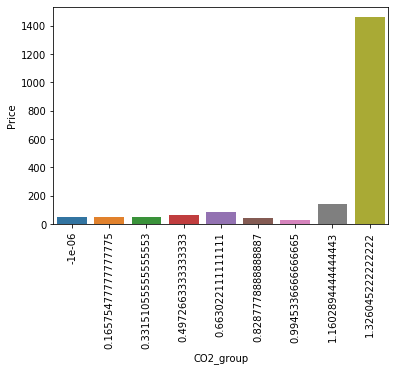

<Figure size 432x288 with 0 Axes>

In [119]:
fig = sns.barplot(test.index, test.Price)
for i in fig.get_xticklabels():
    i.set_rotation(90)
plt.figure()

<Figure size 432x288 with 0 Axes>

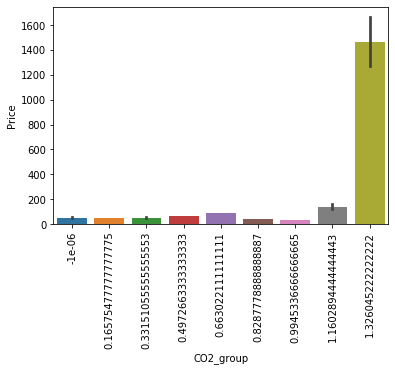

<Figure size 432x288 with 0 Axes>

In [120]:
fig = sns.barplot(df_DUID_CO2_price.CO2_group, df_DUID_CO2_price.Price)
for i in fig.get_xticklabels():
    i.set_rotation(90)
plt.figure()

In [121]:
file_path = '{}/nem-data/nemde_clean/df_DUID_CO2_price.pkl'.format(os.environ['HOME'])
pd.to_pickle(df_DUID_CO2_price, file_path)

In [122]:
df_DUID_CO2_price

,Price,CO2E_EMISSIONS_FACTOR,CO2_group
PeriodID,,,
2018-07-31 23:55:00,70.70204,0.910143,0.828778
2018-07-31 23:50:00,69.24109,0.728114,0.663022
2018-07-31 23:45:00,69.94850,0.910143,0.828778
2018-07-31 23:40:00,74.04497,0.908305,0.828778
2018-07-31 23:35:00,76.44245,0.971761,0.828778
...,...,...,...
2009-07-01 04:20:00,1.75480,1.025701,0.994534
2009-07-01 04:15:00,1.44014,0.991217,0.828778
2009-07-01 04:10:00,-0.00006,0.000000,-0.000001
